In [1]:
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
from tqdm import tqdm
from glob import glob


In [3]:
# Load the test series descriptions
df_test_series = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv")

In [4]:
def readdcm_writepng_image(src_dicom_pixelarray, dest_path_png):
    '''
    Convert DICOM pixel array to PNG with standardized pixel intensity.
    '''
    standardized_image_data = ((src_dicom_pixelarray - src_dicom_pixelarray.min()) / 
                               (src_dicom_pixelarray.max() - src_dicom_pixelarray.min() + 1e-10)) * 255
    final_image_to_png = cv2.resize(standardized_image_data, (512, 512), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(dest_path_png, final_image_to_png)

In [42]:
# Define paths
test_images_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images'
output_path = '/kaggle/working/RSNA_test_images_png/'

# Remove the output directory if it exists (for fresh conversion)
if os.path.isdir(output_path):
    shutil.rmtree(output_path)

# Iterate over the test data
for idx, row in tqdm(df_test_series.iterrows(), total=len(df_test_series)):
    study_id = row['study_id']
    series_id = row['series_id']
    series_desc = row['series_description'].replace(' ', '_').replace('/', '_')
    
    # Define the new directory structure for PNGs
    series_output_dir = f'{output_path}/{study_id}/{series_desc}'
    os.makedirs(series_output_dir, exist_ok=True)
    
    # Get all DICOM files in this series
    series_dicom_dir = f'{test_images_path}/{study_id}/{series_id}'
    dicom_files = glob(f'{series_dicom_dir}/*.dcm')
    
    # Convert each DICOM file to PNG
    for dicom_file in dicom_files:
        dicom_image = pydicom.dcmread(dicom_file)
        image_filename = os.path.splitext(os.path.basename(dicom_file))[0]  # Use SOPInstanceUID for naming
        image_dicom_pixelarray = dicom_image.pixel_array
        
        dest_path = f'{series_output_dir}/{image_filename}.png'
        readdcm_writepng_image(image_dicom_pixelarray, dest_path)

100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Series description: Axial_T2


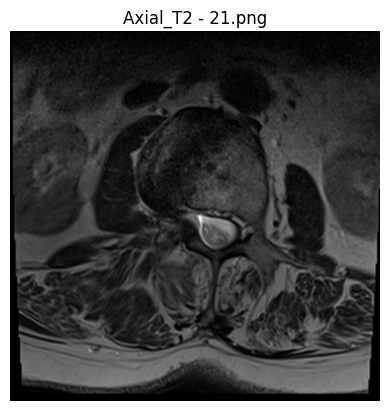

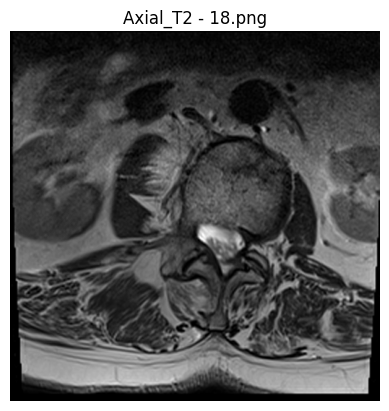

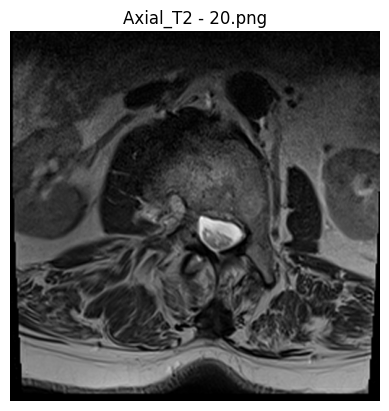

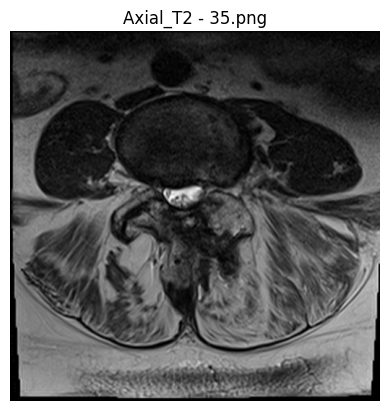

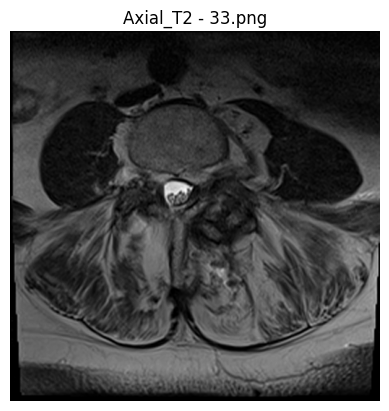

Series description: Sagittal_T1


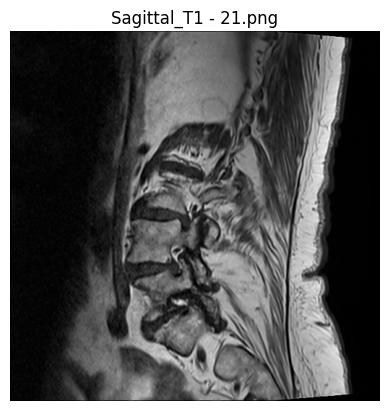

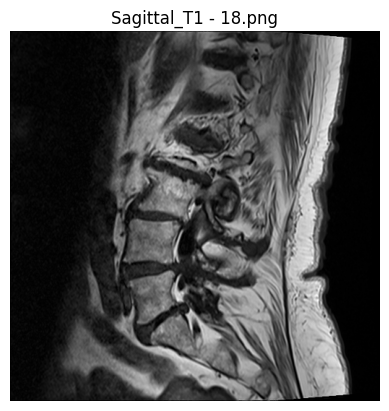

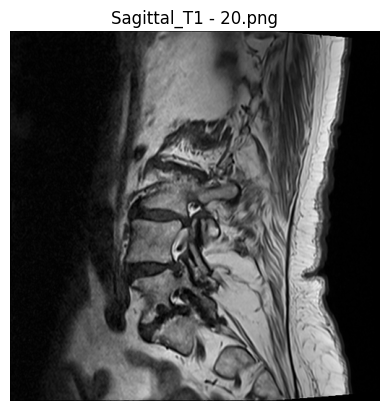

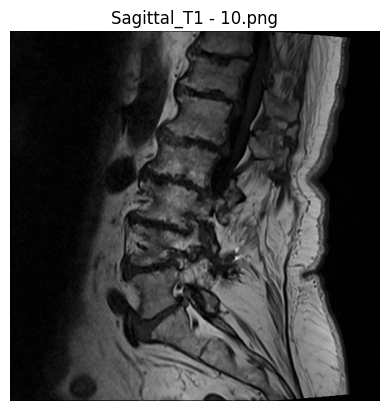

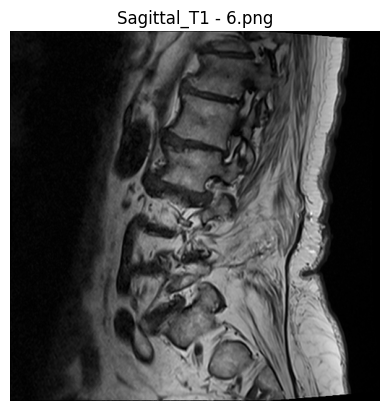

Series description: Sagittal_T2_STIR


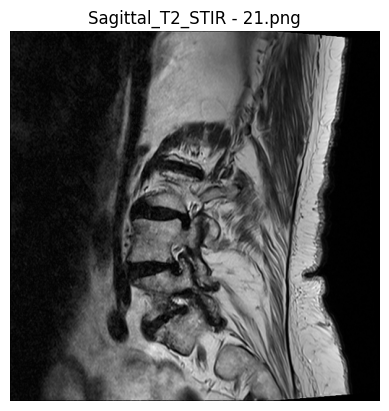

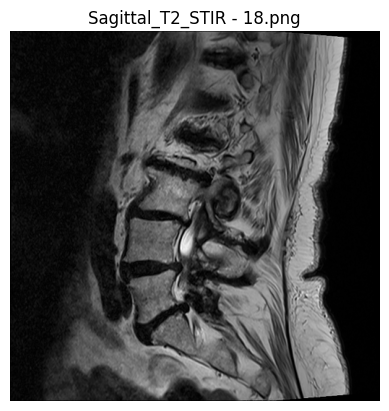

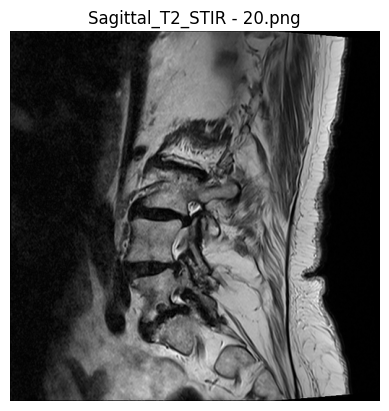

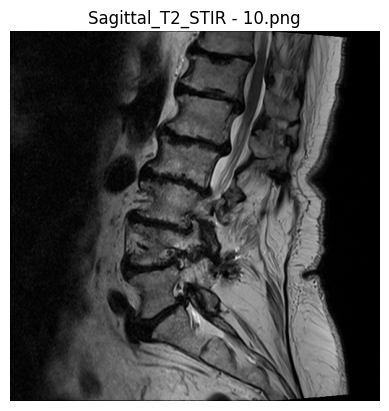

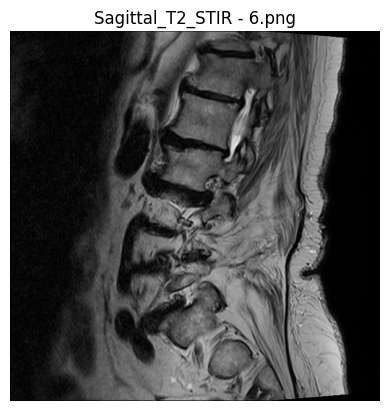

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Example of how to display images
for study_id in df_test_series['study_id'].unique():
    study_dir = f'{output_path}/{study_id}'
    
    for series_desc in os.listdir(study_dir):
        print(f'Series description: {series_desc}')
        png_files = glob(f'{study_dir}/{series_desc}/*.png')
        
        for png_file in png_files[:5]:  # Display first 5 images
            img = Image.open(png_file)
            plt.imshow(img, cmap='gray')
            plt.title(f'{series_desc} - {os.path.basename(png_file)}')
            plt.axis('off')
            plt.show()
